# Telecom Churn Prediction - Starter Notebook

**Author:** Shiva sai Bondugula (shivasaibondugula4@gmail.com)

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Reading & understanding the data

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV

#statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Others
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

Let us load our data dictionary file to understand the columns present in train.csv file

In [2]:
data_dictionary=pd.read_csv("data_dictionary.csv")
print(data_dictionary)

       Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator ne

Let us load the training data

In [3]:
data=pd.read_csv("train.csv")
data.shape

(69999, 172)

In [4]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

Thus the data contains 69999 rows and 172 columns.

In [5]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

# 2. Data cleaning

Let us find if there are any missing values in columns and handle them.

In [6]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df[missing_value_df['percent_missing']>0]

,percent_missing
loc_og_t2o_mou,1.002871
std_og_t2o_mou,1.002871
loc_ic_t2o_mou,1.002871
last_date_of_month_7,0.570008
last_date_of_month_8,1.047158
onnet_mou_6,3.954342
onnet_mou_7,3.838626
onnet_mou_8,5.290076
offnet_mou_6,3.954342
offnet_mou_7,3.838626


We can see some of the columns contains above 70% rows missing values - Hence those columns are not much useful for our predictions. Let us remove those columns.

In [7]:
column_names_with_missing_over_70 = list(missing_value_df[missing_value_df['percent_missing']>70].index)
data.drop(column_names_with_missing_over_70,axis=1,inplace=True)

In [8]:
data.shape

(69999, 142)

In [9]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df[missing_value_df['percent_missing']>0]

,percent_missing
loc_og_t2o_mou,1.002871
std_og_t2o_mou,1.002871
loc_ic_t2o_mou,1.002871
last_date_of_month_7,0.570008
last_date_of_month_8,1.047158
onnet_mou_6,3.954342
onnet_mou_7,3.838626
onnet_mou_8,5.290076
offnet_mou_6,3.954342
offnet_mou_7,3.838626


We can see some of the columns contains less than 6% rows missing values - Hence let us fill those cells with 0.

In [10]:
data = data.fillna(0)

In [11]:
data.shape

(69999, 142)

In [12]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df[missing_value_df['percent_missing']>0]

,percent_missing


Now we can see, we don't have any missing values.

In [13]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 142 columns):
 #    Column                Dtype  
---   ------                -----  
 0    id                    int64  
 1    circle_id             int64  
 2    loc_og_t2o_mou        float64
 3    std_og_t2o_mou        float64
 4    loc_ic_t2o_mou        float64
 5    last_date_of_month_6  object 
 6    last_date_of_month_7  object 
 7    last_date_of_month_8  object 
 8    arpu_6                float64
 9    arpu_7                float64
 10   arpu_8                float64
 11   onnet_mou_6           float64
 12   onnet_mou_7           float64
 13   onnet_mou_8           float64
 14   offnet_mou_6          float64
 15   offnet_mou_7          float64
 16   offnet_mou_8          float64
 17   roam_ic_mou_6         float64
 18   roam_ic_mou_7         float64
 19   roam_ic_mou_8         float64
 20   roam_og_mou_6         float64
 21   roam_og_mou_7         float64
 22   roam_og_mou_8       

In [14]:
data[['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,6/30/2014,7/31/2014,8/31/2014,6/22/2014,7/10/2014,8/24/2014
1,6/30/2014,7/31/2014,8/31/2014,6/12/2014,7/10/2014,8/26/2014
2,6/30/2014,7/31/2014,8/31/2014,6/11/2014,7/22/2014,8/24/2014
3,6/30/2014,7/31/2014,8/31/2014,6/15/2014,7/21/2014,8/25/2014
4,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/26/2014,8/30/2014


From the above data, there are some date columns, let us split those columns to separate date,month and year columns. 
Let us write a custom function to do so.

In [15]:
def split_date_to_individual_columns(data,data_columns):
    for col in data_columns:
        data[col+"_date"]=pd.DatetimeIndex(data[col],dayfirst=True).day
        data[col+"_month"]=pd.DatetimeIndex(data[col],dayfirst=True).month
        data[col+"_year"]=pd.DatetimeIndex(data[col],dayfirst=True).year
        data.drop([col],axis=1,inplace=True)

date_columns = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
split_date_to_individual_columns(data,date_columns)

In [16]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,last_date_of_month_6_date,last_date_of_month_6_month,last_date_of_month_6_year,last_date_of_month_7_date,last_date_of_month_7_month,last_date_of_month_7_year,last_date_of_month_8_date,last_date_of_month_8_month,last_date_of_month_8_year,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_date,date_of_last_rech_8_month,date_of_last_rech_8_year
0,0,109,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.0,0.0,0.0,0,30,6,2014,31,7,2014,31,8,2014,22,6,2014,7,10,2014,24,8,2014
1,1,109,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,710,0.0,0.0,0.0,0,30,6,2014,31,7,2014,31,8,2014,6,12,2014,7,10,2014,26,8,2014
2,2,109,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99

In [17]:
data.shape

(69999, 154)

In [18]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 154 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    id                          int64  
 1    circle_id                   int64  
 2    loc_og_t2o_mou              float64
 3    std_og_t2o_mou              float64
 4    loc_ic_t2o_mou              float64
 5    arpu_6                      float64
 6    arpu_7                      float64
 7    arpu_8                      float64
 8    onnet_mou_6                 float64
 9    onnet_mou_7                 float64
 10   onnet_mou_8                 float64
 11   offnet_mou_6                float64
 12   offnet_mou_7                float64
 13   offnet_mou_8                float64
 14   roam_ic_mou_6               float64
 15   roam_ic_mou_7               float64
 16   roam_ic_mou_8               float64
 17   roam_og_mou_6               float64
 18   roam_og_mou_7               float64
 19   ro

In [19]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,last_date_of_month_6_date,last_date_of_month_6_month,last_date_of_month_6_year,last_date_of_month_7_date,last_date_of_month_7_month,last_date_of_month_7_year,last_date_of_month_8_date,last_date_of_month_8_month,last_date_of_month_8_year,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_date,date_of_last_rech_8_month,date_of_last_rech_8_year
count,69999.000000,69999.0,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00

We can see "id" has unique values, which is not useful for prediction. Let us remove it.

In [20]:
data.id.nunique()

69999

In [21]:
data.drop(["id"],axis=1,inplace=True)

In [22]:
data.shape

(69999, 153)

We can see the below columns contains only one/all unique values. Let us remove those columns as they not useful for prediction.

In [23]:
data[['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','last_date_of_month_6_date','last_date_of_month_6_month','last_date_of_month_6_year','last_date_of_month_7_date','last_date_of_month_7_month','last_date_of_month_7_year','last_date_of_month_8_month','last_date_of_month_8_date','last_date_of_month_8_year','date_of_last_rech_6_year','date_of_last_rech_7_year','date_of_last_rech_8_year']].nunique()

circle_id                     1
loc_og_t2o_mou                1
std_og_t2o_mou                1
loc_ic_t2o_mou                1
std_og_t2c_mou_6              1
std_og_t2c_mou_7              1
std_og_t2c_mou_8              1
std_ic_t2o_mou_6              1
std_ic_t2o_mou_7              1
std_ic_t2o_mou_8              1
last_date_of_month_6_date     1
last_date_of_month_6_month    1
last_date_of_month_6_year     1
last_date_of_month_7_date     2
last_date_of_month_7_month    2
last_date_of_month_7_year     2
last_date_of_month_8_month    2
last_date_of_month_8_date     2
last_date_of_month_8_year     2
date_of_last_rech_6_year      2
date_of_last_rech_7_year      2
date_of_last_rech_8_year      2
dtype: int64

In [24]:
data.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','last_date_of_month_6_date','last_date_of_month_6_month','last_date_of_month_6_year','last_date_of_month_7_date','last_date_of_month_7_month','last_date_of_month_7_year','last_date_of_month_8_month','last_date_of_month_8_date','last_date_of_month_8_year','date_of_last_rech_6_year','date_of_last_rech_7_year','date_of_last_rech_8_year'],axis=1,inplace=True)

In [25]:
data.shape

(69999, 131)

In [26]:
data.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_8_date,date_of_last_rech_8_month
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,283.134365,278.185912,278.858826,127.887939,128.754731,125.943607,191.010582,189.585401,186.146273,9.379276,6.745305,6.634328,13.625476,9.464386,9.254848,45.050076,44.394344,43.269280,89.551272,87.313796,86.301054,3.595161,3.632045,3.467948,1.081499,1.308807,1.345676,138.203540,135.347249,133.045174,77.431415,80.560009,79.055781,84.6

# 3. Data preparation

In [27]:
data.shape

(69999, 131)

As we can see there are 130 features to predit the target variable. We can choose **PCA for dimensionality reduction**(Reducting the features)

Let us find the corelation between these variables.

<AxesSubplot:>

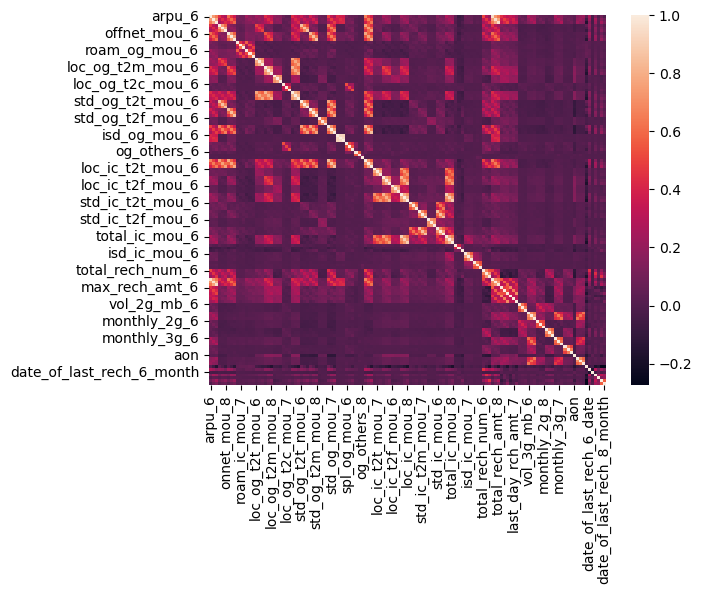

In [28]:
sns.heatmap(data.corr())

We can remove the correlated variables using PCA.

In [29]:
pca_y = data.pop("churn_probability")

In [30]:
data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_8_date,date_of_last_rech_8_month
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.0,0.0,0.0,22,6,7,10,24,8
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,710,0.0,0.0,0.0,6,12,7,10,26,8
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,882,0.0,0.0,0.0,6,11,22,7,24,8
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,16.16,37.99,4.60,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,24.98,4.84,23.88,53.99,44.23,57.14,7.23,0.81,0.

Scaling the data

In [31]:
scaler = StandardScaler()

In [32]:
pca_X = data.copy()

In [33]:
pca_X = scaler.fit_transform(pca_X)

In [34]:
pca = PCA(random_state=42)

In [35]:
pca.fit(pca_X)

PCA(random_state=42)

In [36]:
pca.components_

array([[ 1.79683347e-01,  1.91955615e-01,  1.80946935e-01, ...,
         9.42153271e-03,  5.41937067e-02,  2.85276434e-02],
       [-4.00766871e-02, -5.56632565e-02, -4.81656198e-02, ...,
        -4.35809312e-04, -4.49053496e-02, -7.15979241e-03],
       [ 1.06050724e-01,  1.17629664e-01,  1.18422178e-01, ...,
         5.46912561e-04, -1.73224856e-02,  3.49132781e-03],
       ...,
       [-4.38942345e-07,  2.18876523e-07,  4.38211155e-08, ...,
         5.59105301e-08, -2.14930261e-08,  5.01242803e-08],
       [-1.02884773e-07,  2.39327450e-07,  2.20363758e-07, ...,
         1.13227978e-08, -3.13389419e-08,  8.24949910e-08],
       [ 1.36102647e-07,  7.29244789e-08,  2.04642432e-07, ...,
         4.04059124e-08, -1.85340083e-08,  3.59454804e-08]])

In [37]:
pca.explained_variance_ratio_

array([1.28799343e-01, 7.29626851e-02, 5.03178300e-02, 4.34233916e-02,
       3.54763765e-02, 3.12217248e-02, 2.72512982e-02, 2.62879841e-02,
       2.38351173e-02, 2.32821772e-02, 2.29457680e-02, 2.15828204e-02,
       2.13535440e-02, 2.05022940e-02, 1.93262541e-02, 1.68331647e-02,
       1.58628913e-02, 1.44134932e-02, 1.35589220e-02, 1.32337595e-02,
       1.30101446e-02, 1.26346391e-02, 1.21062310e-02, 1.16300647e-02,
       1.10748327e-02, 1.08059733e-02, 9.50538909e-03, 9.31293214e-03,
       9.09768604e-03, 8.43705041e-03, 7.91538668e-03, 7.76266382e-03,
       7.61453066e-03, 7.49419664e-03, 7.30643056e-03, 7.15903596e-03,
       6.91144934e-03, 6.72615014e-03, 6.62570217e-03, 6.37176946e-03,
       6.27993360e-03, 6.24924394e-03, 6.02068232e-03, 5.59998036e-03,
       5.50444541e-03, 5.24944642e-03, 5.19006639e-03, 5.04336102e-03,
       4.78474503e-03, 4.53989467e-03, 4.39879730e-03, 4.25557715e-03,
       4.11992164e-03, 3.97552074e-03, 3.92015767e-03, 3.81244726e-03,
      

<BarContainer object of 130 artists>

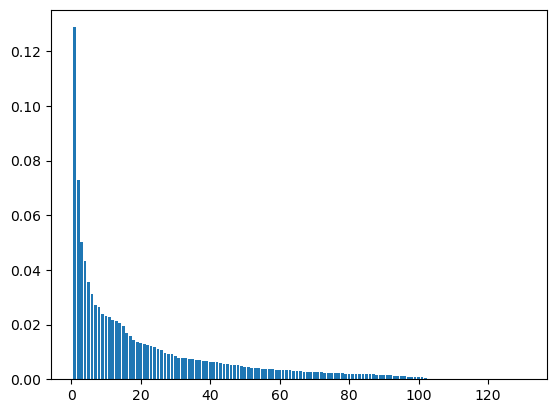

In [38]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [39]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

#### Making the scree plot

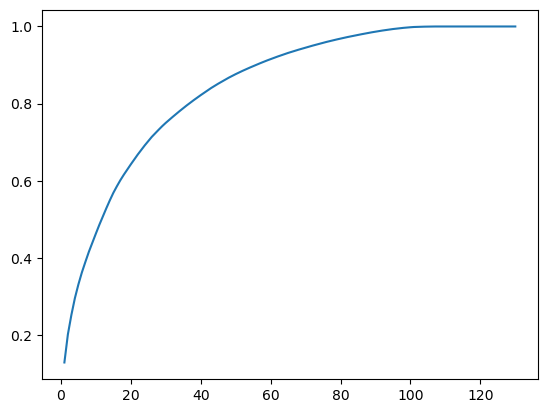

In [40]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

PCA with 60 components

In [41]:
pc2 = PCA(n_components=60, random_state=42)

In [42]:
newdata = pc2.fit_transform(pca_X)

In [44]:
newdata.shape

(69999, 60)

Making a dataframe out of it for convenience

In [45]:
df = pd.DataFrame(newdata, columns=["PC"+str(x) for x in range(1,61)])
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
0,-3.574153,-0.762018,-0.364621,0.020442,0.820764,-0.388655,-0.006579,-0.200084,-0.077149,-0.021303,0.566514,-0.059586,-0.053782,0.242257,0.038232,0.130153,0.121528,-0.267311,-0.028998,-0.184715,0.339828,0.511014,-0.173137,-0.842322,0.785727,-0.030711,0.612441,-0.177998,0.637810,0.836450,0.148933,-1.360963,-1.350502,-0.332488,2.375967,1.077215,-0.524311,-0.538392,-0.203533,2.816171,-0.352228,1.013372,1.634092,0.189927,-0.087207,-0.309019,0.786534,-2.091621,1.507859,0.639835,-0.569310,0.557381,0.101970,-0.050658,0.293379,0.189852,-0.016563,-0.135297,0.167956,-0.018441
1,-3.837479,-0.454289,0.585074,-0.073276,-0.380147,-0.097499,-0.164228,-0.033151,1.308365,-0.085892,0.470473,-1.753665,1.390557,3.310009,0.358366,0.352880,-0.038566,0.496709,0.034271,0.418843,-0.249589,-0.321767,-0.668044,-0.314583,0.035241,-0.850634,1.398547,2.241877,0.050833,4.383411,-2.689610,-1.529351,0.897157,-2.849334,0.127307,-0.445563,0.957806,0.354481,1.265758,-0.355473,-1.315205,0.578012,-0.257229,0.569908,-0.482885,-0.216447,0.712182,-2.072758,0.770353,1.193578,-0.543214,-0.143852,0.816111,0.367269,-0.152115,-0.086016,0.033772,0.102624,-0.327203,-0.240011
2,-3.672015,-0.159058,-0.244774,-0.072081,0.903129,-0.255899,0.001017,-0.298122,-0.302207,-0.011082,0.470643,-0.052819,-0.207558,0.322980,0.199532,0.292134,-0.134921,0.600023,0.091014,0.058382,-0.077676,-0.174549,-0.022040,-0.000374,-0.058123,-0.472252,1.082174,0.792994,-0.250266,2.632306,-2.629337,0.579336,0.232519,-0.452404,0.458407,1.261421,-0.181429,0.560051,-0.005415,-0.576953,-0.251178,-0.394279,-0.534926,-0.216535,0.098428,0.004948,0.118660,0.166120,-0.431617,0.072727,0.015569,-0.015031,-0.353037,-0.014283,-0.015348,0.037344,0.133455,-0.122094,-0.012787,0.097103
3,-2.659012,-0.089629,0.110995,-0.369850,0.773903,0.068363,0.111351,-0.168193,0.243274,-0.062883,0.320333,-0.794538,0.428298,1.190394,0.120284,0.038534,-0.499205,0.493610,-0.108338,0.211532,-0.053462,-0.062119,-0.129829,-0.477685,-0.316352,-0.462258,0.150505,0.058003,-0.032737,0.122013,-0.021851,-0.343890,-0.246619,-0.513380,0.230893,0.316976,0.114434,0.057070,0.482030,-0.475255,0.431941,-0.585296,0.011262,-0.444023,-0.296655,-0.759543,-0.336847,-0.592435,-0.407812,0.234254,0.128964,-0.096835,-0.341241,-0.029456,0.040815,0.049491,0.071351,-0.108496,-0.068128,0.155094
4,-2.711255,-0.811946,0.803165,-0.190602,-3.630426,1.774460,0.463710,3.007544,0.512117,-0.884498,-2.438644,0.314148,-0.238957,-1.371934,-0.526380,1.259290,-1.355159,-0.582795,-0.638955,2.581739,-0.833442,-1.054607,-0.286962,-0.150086,-0.182326,-0.025011,0.516785,-0.960927,0.107330,0.767227,0.228941,-0.646747,-0.201247,0.119253,-0.168093,-0.214143,-0.400788,-0.063208,0.415872,-0.489156,-0.254049,-0.437659,0.421805,0.852709,0.363402,1.127170,0.632118,-0.006174,-0.040901,-0.119828,-0.034137,-0.372654,-0.095816,0.005160,-0.272627,-0.267686,-0.197682,0.060002,0.027106,0.531152


In [46]:
df_final = pd.concat([df.reset_index(), pca_y.reset_index()], axis=1)
df_final.head()

,index,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,index,churn_probability
0,0,-3.574153,-0.762018,-0.364621,0.020442,0.820764,-0.388655,-0.006579,-0.200084,-0.077149,-0.021303,0.566514,-0.059586,-0.053782,0.242257,0.038232,0.130153,0.121528,-0.267311,-0.028998,-0.184715,0.339828,0.511014,-0.173137,-0.842322,0.785727,-0.030711,0.612441,-0.177998,0.637810,0.836450,0.148933,-1.360963,-1.350502,-0.332488,2.375967,1.077215,-0.524311,-0.538392,-0.203533,2.816171,-0.352228,1.013372,1.634092,0.189927,-0.087207,-0.309019,0.786534,-2.091621,1.507859,0.639835,-0.569310,0.557381,0.101970,-0.050658,0.293379,0.189852,-0.016563,-0.135297,0.167956,-0.018441,0,0
1,1,-3.837479,-0.454289,0.585074,-0.073276,-0.380147,-0.097499,-0.164228,-0.033151,1.308365,-0.085892,0.470473,-1.753665,1.390557,3.310009,0.358366,0.352880,-0.038566,0.496709,0.034271,0.418843,-0.249589,-0.321767,-0.668044,-0.314583,0.035241,-0.850634,1.398547,2.241877,0.050833,4.383411,-2.689610,-1.529351,0.897157,-2.849334,0.127307,-0.445563,0.957806,0.354481,1.265758,-0.355473,-1.315205,0.578012,-0.257229,0.569908,-0.482885,-0.216447,0.712182,-2.072758,0.770353,1.193578,-0.543214,-0.143852,0.816111,0.367269,-0.152115,-0.086016,0.033772,0.102624,-0.327203,-0.240011,1,0
2,2,-3.672015,-0.159058,-0.244774,-0.072081,0.903129,-0.255899,0.001017,-0.298122,-0.302207,-0.011082,0.470643,-0.052819,-0.207558,0.322980,0.199532,0.292134,-0.134921,0.600023,0.091014,0.058382,-0.077676,-0.174549,-0.022040,-0.000374,-0.058123,-0.472252,1.082174,0.792994,-0.250266,2.632306,-2.629337,0.579336,0.232519,-0.452404,0.458407,1.261421,-0.181429,0.560051,-0.005415,-0.576953,-0.251178,-0.394279,-0.534926,-0.216535,0.098428,0.004948,0.118660,0.166120,-0.431617,0.072727,0.015569,-0.015031,-0.353037,-0.014283,-0.015348,0.037344,0.133455,-0.122094,-0.012787,0.097103,2,0
3,3,-2.659012,-0.089629,0.110995,-0.369850,0.773903,0.068363,0.111351,-0.168193,0.243274,-0.062883,0.320333,-0.794538,0.428298,1.190394,0.120284,0.038534,-0.499205,0.493610,-0.108338,0.211532,-0.053462,-0.062119,-0.129829,-0.477685,-0.316352,-0.462258,0.150505,0.058003,-0.032737,0.122013,-0.021851,-0.343890,-0.246619,-0.513380,0.230893,0.316976,0.114434,0.057070,0.482030,-0.475255,0.431941,-0.585296,0.011262,-0.444023,-0.296655,-0.759543,-0.336847,-0.592435,-0.407812,0.234254,0.128964,-0.096835,-0.341241,-0.029456,0.040815,0.049491,0.071351,-0.108496,-0.068128,0.155094,3,0
4,4,-2.711255,-0.811946,0.803165,-0.190602,-3.630426,1.774460,0.463710,3.007544,0.512117,-0.884498,-2.438644,0.314148,-0.238957,-1.371934,-0.526380,1.259290,-1.355159,-0.582795,-0.638955,2.581739,-0.833442,-1.054607,-0.286962,-0.150086,-0.182326,-0.025011,0.516785,-0.960927,0.107330,0.767227,0.228941,-0.646747,-0.201247,0.119253,-0.168093,-0.214143,-0.400788,-0.063208,0.415872,-0.489156,-0.254049,-0.437659,0.421805,0.852709,0.363402,1.127170,0.632118,-0.006174,-0.040901,-0.119828,-0.034137,-0.372654,-0.095816,0.005160,-0.272627,-0.267686,-0.197682,0.060002,0.027106,0.531152,4,0


In [47]:
df_final.drop(["index"],axis=1,inplace=True)
df_final.shape

(69999, 61)

In [48]:
df_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,churn_probability
0,-3.574153,-0.762018,-0.364621,0.020442,0.820764,-0.388655,-0.006579,-0.200084,-0.077149,-0.021303,0.566514,-0.059586,-0.053782,0.242257,0.038232,0.130153,0.121528,-0.267311,-0.028998,-0.184715,0.339828,0.511014,-0.173137,-0.842322,0.785727,-0.030711,0.612441,-0.177998,0.637810,0.836450,0.148933,-1.360963,-1.350502,-0.332488,2.375967,1.077215,-0.524311,-0.538392,-0.203533,2.816171,-0.352228,1.013372,1.634092,0.189927,-0.087207,-0.309019,0.786534,-2.091621,1.507859,0.639835,-0.569310,0.557381,0.101970,-0.050658,0.293379,0.189852,-0.016563,-0.135297,0.167956,-0.018441,0
1,-3.837479,-0.454289,0.585074,-0.073276,-0.380147,-0.097499,-0.164228,-0.033151,1.308365,-0.085892,0.470473,-1.753665,1.390557,3.310009,0.358366,0.352880,-0.038566,0.496709,0.034271,0.418843,-0.249589,-0.321767,-0.668044,-0.314583,0.035241,-0.850634,1.398547,2.241877,0.050833,4.383411,-2.689610,-1.529351,0.897157,-2.849334,0.127307,-0.445563,0.957806,0.354481,1.265758,-0.355473,-1.315205,0.578012,-0.257229,0.569908,-0.482885,-0.216447,0.712182,-2.072758,0.770353,1.193578,-0.543214,-0.143852,0.816111,0.367269,-0.152115,-0.086016,0.033772,0.102624,-0.327203,-0.240011,0
2,-3.672015,-0.159058,-0.244774,-0.072081,0.903129,-0.255899,0.001017,-0.298122,-0.302207,-0.011082,0.470643,-0.052819,-0.207558,0.322980,0.199532,0.292134,-0.134921,0.600023,0.091014,0.058382,-0.077676,-0.174549,-0.022040,-0.000374,-0.058123,-0.472252,1.082174,0.792994,-0.250266,2.632306,-2.629337,0.579336,0.232519,-0.452404,0.458407,1.261421,-0.181429,0.560051,-0.005415,-0.576953,-0.251178,-0.394279,-0.534926,-0.216535,0.098428,0.004948,0.118660,0.166120,-0.431617,0.072727,0.015569,-0.015031,-0.353037,-0.014283,-0.015348,0.037344,0.133455,-0.122094,-0.012787,0.097103,0
3,-2.659012,-0.089629,0.110995,-0.369850,0.773903,0.068363,0.111351,-0.168193,0.243274,-0.062883,0.320333,-0.794538,0.428298,1.190394,0.120284,0.038534,-0.499205,0.493610,-0.108338,0.211532,-0.053462,-0.062119,-0.129829,-0.477685,-0.316352,-0.462258,0.150505,0.058003,-0.032737,0.122013,-0.021851,-0.343890,-0.246619,-0.513380,0.230893,0.316976,0.114434,0.057070,0.482030,-0.475255,0.431941,-0.585296,0.011262,-0.444023,-0.296655,-0.759543,-0.336847,-0.592435,-0.407812,0.234254,0.128964,-0.096835,-0.341241,-0.029456,0.040815,0.049491,0.071351,-0.108496,-0.068128,0.155094,0
4,-2.711255,-0.811946,0.803165,-0.190602,-3.630426,1.774460,0.463710,3.007544,0.512117,-0.884498,-2.438644,0.314148,-0.238957,-1.371934,-0.526380,1.259290,-1.355159,-0.582795,-0.638955,2.581739,-0.833442,-1.054607,-0.286962,-0.150086,-0.182326,-0.025011,0.516785,-0.960927,0.107330,0.767227,0.228941,-0.646747,-0.201247,0.119253,-0.168093,-0.214143,-0.400788,-0.063208,0.415872,-0.489156,-0.254049,-0.437659,0.421805,0.852709,0.363402,1.127170,0.632118,-0.006174,-0.040901,-0.119828,-0.034137,-0.372654,-0.095816,0.005160,-0.272627,-0.267686,-0.197682,0.060002,0.027106,0.531152,0


<AxesSubplot:>

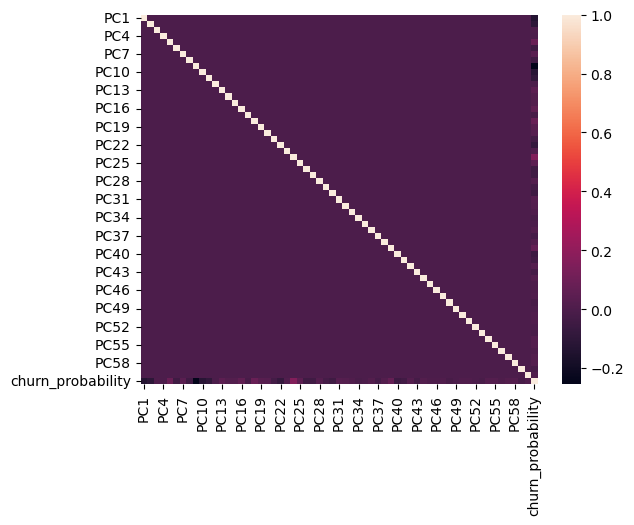

In [49]:
sns.heatmap(df_final.corr())

Thus we can see there is no correlation between any of the features now.

# 4. Splitting the data into training and testing sets

In [50]:
df_train, df_test = train_test_split(df_final, train_size = 0.7, test_size = 0.3, random_state = 100,stratify=df_final.churn_probability)

In [51]:
df_train.shape

(48999, 61)

In [52]:
df_test.shape

(21000, 61)

In [54]:
y_train = df_train.pop('churn_probability')
X_train = df_train

In [55]:
y_train.head()

61966    0
27769    0
14848    0
24960    0
27245    0
Name: churn_probability, dtype: int64

In [56]:
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
61966,-3.129504,-0.196613,-0.726240,-0.378272,-0.135856,0.442481,0.195226,0.203211,-0.025653,0.263256,1.085835,-0.395019,0.263106,-0.070795,-0.055277,-0.846573,0.675651,-1.697773,0.346451,-0.769495,1.387801,1.449119,-0.544108,-1.211284,6.945590,2.940598,0.224115,-0.650437,-0.214186,0.309225,0.660367,-0.499503,-0.195701,-0.163518,0.112883,0.305278,-0.695722,-0.081911,-0.640400,1.009870,0.214491,0.402393,0.478068,0.096745,0.246253,0.194417,-0.138066,0.139944,0.884186,-0.318968,2.593431,-0.501945,-0.029278,0.266028,-0.029405,0.108491,-0.112324,0.109170,-0.411631,0.125523
27769,0.068706,-2.564002,-0.537704,0.121331,0.756183,1.996233,-1.132170,-0.636397,-1.176462,-0.010553,0.524727,0.717557,0.121985,-0.178902,0.390392,0.410041,0.497497,-0.848446,0.458779,-0.234335,-0.321964,0.672632,-0.286155,-0.873411,0.123368,-0.102827,0.431298,-0.128830,0.615629,0.088537,0.800290,-0.430752,-0.495182,-0.853706,0.842285,1.580670,-0.199797,0.099548,-0.653785,1.278645,0.066918,0.464605,0.401003,-0.571459,-0.480216,0.670253,-0.064780,0.603555,-0.167654,0.069589,0.229634,0.079494,-0.189556,0.085093,-0.081626,-0.357800,0.428299,0.190184,-0.510895,0.030332
14848,-2.484696,-1.572756,-0.302098,-0.061679,0.329804,0.475044,-0.222662,-0.059381,0.444830,0.649864,1.000097,-0.082609,-0.144368,0.001522,0.191827,0.028942,0.283177,-0.504669,0.380559,-0.120554,0.193028,0.380902,-0.184702,-0.109886,1.711041,-0.537550,0.096456,-0.088107,-0.083787,-0.050978,0.829501,-0.384729,-0.672151,-0.551568,0.918435,1.531634,-1.070256,-0.146433,-0.091408,0.968878,-0.657595,0.327412,0.059740,0.544269,0.107299,0.176704,-0.237192,-0.494834,1.045350,0.143660,0.825652,0.528785,-0.118143,0.081398,0.077259,0.018773,-0.105403,-0.121147,-0.330348,0.148160
24960,-2.567684,0.908650,-0.342381,-0.589729,1.013052,-0.251300,0.054588,-0.280343,0.702158,0.770038,0.658658,-0.006577,-0.297802,0.001845,-0.089839,0.041491,-0.202070,0.637679,-0.092651,0.090840,-0.122439,-0.248880,0.110925,-0.393587,-0.552715,-0.816994,0.497450,0.241834,-0.035744,0.476845,0.459321,0.172828,-0.229596,0.171210,0.203994,-0.682780,0.155265,0.022566,-1.249147,0.127164,1.398481,-0.229303,0.777461,0.146056,-0.131702,-0.704178,0.853060,-0.250045,-1.169650,-0.368700,0.072936,-0.357534,-0.741402,0.123806,0.026944,0.098766,0.072243,0.004123,0.105149,0.182330
27245,6.283753,-10.088170,-1.732913,-1.240407,-0.821725,-7.243891,3.596689,-4.271822,2.122922,-2.561068,-1.349190,0.181961,-0.825779,-1.218532,-1.276999,-1.888074,-1.163811,0.683702,-2.167988,-0.013264,0.601343,0.130717,0.830961,-0.073772,-0.118151,-0.527827,0.059130,0.089838,-0.455403,1.203507,0.868033,-0.540469,-0.700817,0.369482,-0.220637,0.141801,-0.358255,-0.156227,0.491133,-0.041794,0.088175,-0.044161,0.072070,0.395309,0.779261,0.046017,-0.546777,0.333587,0.074596,-0.042155,0.315718,0.365222,-0.289491,0.104911,0.148796,-0.118455,-0.101197,-0.224342,-0.000626,0.074876


In [57]:
y_test = df_test.pop('churn_probability')
X_test = df_test

In [58]:
y_test.head()

59477    0
46310    1
67241    0
59112    0
9609     0
Name: churn_probability, dtype: int64

In [59]:
X_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
59477,-1.103280,0.892017,-0.366496,-0.732090,0.374886,-0.059316,0.516677,-0.096743,-0.339441,0.420554,0.332777,-0.100787,-0.239734,-0.141863,0.418329,-0.287524,-0.471437,-0.462652,-0.254116,-0.061654,0.151912,0.320352,0.052379,-1.076446,-0.840207,0.201299,-0.054238,-0.110615,0.094533,-0.587818,-0.006558,0.058835,-0.053416,-0.036873,0.207746,-0.272314,0.231923,-0.089699,0.118292,-0.218569,-0.083011,-0.292507,-0.635156,0.199698,-0.095079,0.388916,-0.190138,0.230152,0.367283,-0.490744,0.096348,-0.079643,0.166408,0.047095,-0.035308,0.071893,0.026178,-0.009894,-0.196869,-0.080998
46310,-3.685757,-0.140606,1.480390,0.146183,-0.511443,-0.488283,-0.090058,0.021600,-0.849514,-0.675263,-0.183448,0.507713,-0.469655,0.132016,0.178857,-0.016687,0.415643,-0.015845,0.394902,-1.243106,0.304466,0.938071,-0.120036,-0.271731,-0.637907,0.295801,0.329074,-1.256980,1.034984,0.201362,-1.452563,-2.052284,-0.619988,1.425264,0.498427,-0.186809,0.883352,0.608201,2.211598,0.080385,-0.358966,1.125182,1.203010,1.180675,-0.545813,0.099896,0.567820,-2.900919,0.853389,-0.435104,-0.426285,1.211187,-0.234090,0.436004,-0.488339,0.166313,-0.093725,-0.332562,-0.626413,-1.544186
67241,-3.376230,-0.798942,-0.356192,-0.153677,0.203016,0.283142,0.114360,0.034263,-0.657696,-0.474287,0.431568,0.197739,0.615640,-0.103839,-0.021755,-0.078942,0.368311,-0.920205,0.120836,-0.130906,0.585567,0.632041,0.093033,-0.384020,1.127586,0.351644,-0.102204,-0.428172,0.493667,-0.363080,-0.252581,-0.308554,0.005858,0.608203,-0.888749,0.204563,-0.148558,0.464268,0.498536,-0.465544,-0.025049,-0.173887,-0.006384,-0.737394,0.181377,0.150593,-0.065748,-0.004208,0.906700,-0.160304,1.790166,-0.438962,-0.116748,0.184709,0.144774,0.246394,-0.092567,-0.007068,-0.170828,-0.164590
59112,1.500049,1.386165,-2.422892,0.464669,-2.313251,0.887648,0.697624,0.948693,-0.942569,1.126559,0.402790,-0.991635,0.227554,-0.617378,0.121417,-0.945099,0.613902,-1.158907,-0.854568,-0.675460,0.261150,0.221593,0.682046,1.012064,-0.888742,-0.165503,-0.585940,-0.115842,0.979735,-0.746195,-0.552694,1.597621,0.500770,-0.179802,-0.334472,0.396071,0.631563,-0.778884,-0.534335,0.249664,-0.179716,-0.070577,-0.637919,-0.018638,-0.317451,-0.729499,0.650579,-0.760623,-0.190740,-0.103849,0.093077,-0.246920,0.184912,-0.136903,0.061591,0.549113,0.246378,0.045307,0.636670,-0.129833
9609,7.301305,1.849925,-1.994511,-4.849955,-0.270087,-2.759949,0.617039,4.039388,-0.466475,3.461457,0.954528,0.140031,0.266666,-0.223816,1.206231,0.576583,1.414757,-0.068016,0.202548,-0.405544,-0.120064,-0.444909,-0.023454,0.165960,0.028431,-0.590155,-0.222623,0.160378,0.253673,-1.013091,-0.216773,0.678149,0.014385,-0.501649,0.521218,0.586893,0.058120,1.385164,0.719122,-0.958599,0.479445,1.295067,0.001892,-0.481277,-0.582368,0.978336,0.030400,0.569093,0.014752,1.777480,0.556233,1.387138,-0.470075,1.308748,1.103299,0.785393,0.602237,1.795640,-0.225000,-0.159330


# 6. Building our model and evaluating

### Let us first use Logistic regression

#### Feature selection using RFE

In [60]:
logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [61]:
rfe.support_

array([ True,  True, False, False,  True, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False])

In [62]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('PC1', True, 1),
 ('PC2', True, 1),
 ('PC3', False, 16),
 ('PC4', False, 17),
 ('PC5', True, 1),
 ('PC6', False, 10),
 ('PC7', False, 5),
 ('PC8', False, 38),
 ('PC9', True, 1),
 ('PC10', True, 1),
 ('PC11', True, 1),
 ('PC12', False, 41),
 ('PC13', False, 13),
 ('PC14', False, 32),
 ('PC15', False, 35),
 ('PC16', False, 8),
 ('PC17', False, 37),
 ('PC18', False, 40),
 ('PC19', False, 36),
 ('PC20', False, 34),
 ('PC21', True, 1),
 ('PC22', False, 20),
 ('PC23', False, 25),
 ('PC24', True, 1),
 ('PC25', False, 21),
 ('PC26', True, 1),
 ('PC27', False, 26),
 ('PC28', False, 15),
 ('PC29', False, 6),
 ('PC30', True, 1),
 ('PC31', True, 1),
 ('PC32', False, 29),
 ('PC33', True, 1),
 ('PC34', False, 22),
 ('PC35', True, 1),
 ('PC36', False, 2),
 ('PC37', False, 14),
 ('PC38', True, 1),
 ('PC39', True, 1),
 ('PC40', True, 1),
 ('PC41', True, 1),
 ('PC42', False, 4),
 ('PC43', True, 1),
 ('PC44', True, 1),
 ('PC45', False, 18),
 ('PC46', False, 30),
 ('PC47', False, 23),
 ('PC48', False, 1

In [63]:
col = X_train.columns[rfe.support_]

In [64]:
X_train.columns[~rfe.support_]

Index(['PC3', 'PC4', 'PC6', 'PC7', 'PC8', 'PC12', 'PC13', 'PC14', 'PC15',
       'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC22', 'PC23', 'PC25', 'PC27',
       'PC28', 'PC29', 'PC32', 'PC34', 'PC36', 'PC37', 'PC42', 'PC45', 'PC46',
       'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC53', 'PC54', 'PC55', 'PC56',
       'PC57', 'PC58', 'PC59', 'PC60'],
      dtype='object')

In [65]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                48999
Model:                            GLM   Df Residuals:                    48978
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11015.
Date:                Thu, 29 Jun 2023   Deviance:                       22031.
Time:                        23:44:56   Pearson chi2:                 1.73e+08
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1884
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6425      0.038    -95.511      0.000      -3.717      -3.568
PC1           -0.4248      0.010    -41.497      0.000      -0.445      -0.405
PC2           -0.3570      0.013    -28.182      0.000      -0.382      -0.332
PC5            0.2601      0.016     16.741      0.000       0.230       0.291
PC9           -0.6212      0.016    -39.765      0.000      -0.652      -0.591
PC10          -0.2828      0.012    -22.954      0.000      -0.307      -0.259
PC11          -0.2259      0.015    -15.469      0.000      -0.255      -0.197
PC21          -0.2828      0.025    -11.174      0.000      -0.332      -0.233
PC24           0.3128      0.018     17.070      0.000       0.277       0.349
PC26          -0.4302      0.017    -25.069      0.000      -0.464      -0.397
PC30          -0.2931      0.020    -14.801      0.000      -0.332      -0.254
PC31          -0.2539      0.022    -11.359      0.000      -0.298      -0.210
PC33          -0.5635      0.055    -10.281      0.000      -0.671      -0.456
PC35          -0.3838      0.027    -14.209      0.000      -0.437      -0.331
PC38           0.3468      0.020     17.713      0.000       0.308       0.385
PC39           0.2390      0.024      9.982      0.000       0.192       0.286
PC40          -0.3474      0.026    -13.335      0.000      -0.398      -0.296
PC41          -0.2980      0.027    -11.218      0.000      -0.350      -0.246
PC43          -0.3005      0.028    -10.617      0.000      -0.356      -0.245
PC44           0.3007      0.028     10.926      0.000       0.247       0.355
PC52          -0.1879      0.026     -7.127      0.000      -0.240      -0.136
==============================================================================
"""

In [66]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

61966    0.004380
27769    0.037370
14848    0.056270
24960    0.014318
27245    0.039422
32960    0.116914
9533     0.000329
767      0.332839
27902    0.002717
21840    0.060625
dtype: float64

In [67]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([4.38036027e-03, 3.73698769e-02, 5.62697447e-02, 1.43184396e-02,
       3.94216821e-02, 1.16914035e-01, 3.29353659e-04, 3.32839005e-01,
       2.71726288e-03, 6.06249049e-02])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [68]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final.head()

,Churn,Churn_Prob
0,0,0.004380
1,0,0.037370
2,0,0.056270
3,0,0.014318
4,0,0.039422


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [69]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.004380,0
1,0,0.037370,0
2,0,0.056270,0
3,0,0.014318,0
4,0,0.039422,0


In [70]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[43348   659]
 [ 3571  1421]]


In [71]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.9136717075858691


#### Checking VIFs

In [72]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,PC35,1.01
11,PC33,1.01
0,PC1,1.00
1,PC2,1.00
18,PC44,1.00
17,PC43,1.00
16,PC41,1.00
15,PC40,1.00
14,PC39,1.00
13,PC38,1.00


We can see the VIF is clearly low for all the features.

#### Metrics beyond simply accuracy

In [73]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [74]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.28465544871794873

In [75]:
# Let us calculate specificity
TN / float(TN+FP)

0.9850251096416479

In [76]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.01497489035835208


In [77]:
# positive predictive value 
print (TP / float(TP+FP))

0.6831730769230769


In [78]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9238901084848355


#### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [79]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [80]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

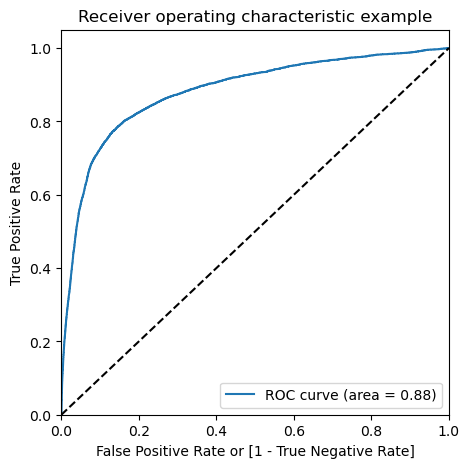

In [81]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

#### Making predictions on the test set

In [82]:
X_test_rfe = X_test[col]
X_test_rfe.head()

,PC1,PC2,PC5,PC9,PC10,PC11,PC21,PC24,PC26,PC30,PC31,PC33,PC35,PC38,PC39,PC40,PC41,PC43,PC44,PC52
59477,-1.103280,0.892017,0.374886,-0.339441,0.420554,0.332777,0.151912,-1.076446,0.201299,-0.587818,-0.006558,-0.053416,0.207746,-0.089699,0.118292,-0.218569,-0.083011,-0.635156,0.199698,-0.079643
46310,-3.685757,-0.140606,-0.511443,-0.849514,-0.675263,-0.183448,0.304466,-0.271731,0.295801,0.201362,-1.452563,-0.619988,0.498427,0.608201,2.211598,0.080385,-0.358966,1.203010,1.180675,1.211187
67241,-3.376230,-0.798942,0.203016,-0.657696,-0.474287,0.431568,0.585567,-0.384020,0.351644,-0.363080,-0.252581,0.005858,-0.888749,0.464268,0.498536,-0.465544,-0.025049,-0.006384,-0.737394,-0.438962
59112,1.500049,1.386165,-2.313251,-0.942569,1.126559,0.402790,0.261150,1.012064,-0.165503,-0.746195,-0.552694,0.500770,-0.334472,-0.778884,-0.534335,0.249664,-0.179716,-0.637919,-0.018638,-0.246920
9609,7.301305,1.849925,-0.270087,-0.466475,3.461457,0.954528,-0.120064,0.165960,-0.590155,-1.013091,-0.216773,0.014385,0.521218,1.385164,0.719122,-0.958599,0.479445,0.001892,-0.481277,1.387138


In [83]:
X_test_sm = sm.add_constant(X_test_rfe)

Making predictions on the test set

In [84]:
y_test_pred = res.predict(X_test_sm)

In [85]:
y_test_pred[:10]

59477    0.033692
46310    0.344013
67241    0.260837
59112    0.007541
9609     0.000576
31981    0.003417
32531    0.001439
59009    0.039489
28243    0.007451
57266    0.022697
dtype: float64

In [86]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [87]:
# Let's see the head
y_pred_1.head()

,0
59477,0.033692
46310,0.344013
67241,0.260837
59112,0.007541
9609,0.000576


In [88]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [89]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [90]:
y_pred_final.head()

,churn_probability,0
59477,0,0.033692
46310,1,0.344013
67241,0,0.260837
59112,0,0.007541
9609,0,0.000576


In [91]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [92]:
y_pred_final.head()

,churn_probability,Churn_Prob
59477,0,0.033692
46310,1,0.344013
67241,0,0.260837
59112,0,0.007541
9609,0,0.000576


In [93]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

In [94]:
y_pred_final.head()

,churn_probability,Churn_Prob,final_predicted
59477,0,0.033692,0
46310,1,0.344013,0
67241,0,0.260837,0
59112,0,0.007541,0
9609,0,0.000576,0


In [95]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.final_predicted)

0.9134761904761904

In [96]:
confusion2 = metrics.confusion_matrix(y_pred_final.churn_probability, y_pred_final.final_predicted )
confusion2

array([[18609,   251],
       [ 1566,   574]], dtype=int64)

In [97]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [98]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.26822429906542056

In [99]:
# Let us calculate specificity
TN / float(TN+FP)

0.9866914103923647

#### Thus the accuracy score on test data when using the logistic regression with 20 features is 91.34

## Using Decision Trees

In [100]:
X_train.shape, X_test.shape

((48999, 60), (21000, 60))

In [101]:
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)

In [102]:
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [103]:
y_train_pred = dt_base.predict(X_train)
y_test_pred = dt_base.predict(X_test)

In [104]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     18860
           1       0.59      0.31      0.40      2140

    accuracy                           0.91     21000
   macro avg       0.76      0.64      0.68     21000
weighted avg       0.89      0.91      0.89     21000



#### Plot the ROC curve

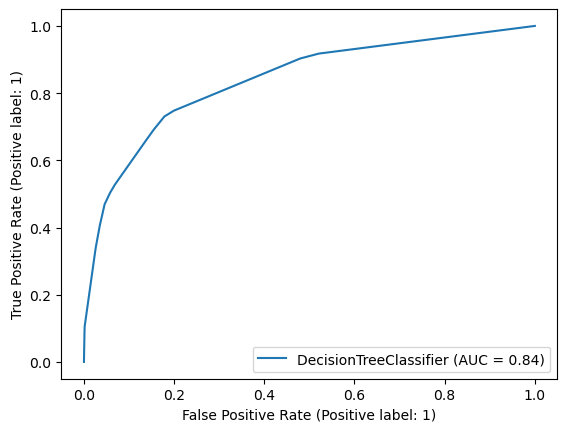

In [105]:
plot_roc_curve(dt_base, X_train, y_train, drop_intermediate=False)
plt.show()

In [106]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred, y_test)

0.9071904761904762

#### Thus the accuracy score on test data when using the basic decision tree with default hyperparameters is 90.71

#### Hyper-parameter tuning for the Decision Tree

In [107]:
dt = DecisionTreeClassifier(random_state=42)

In [108]:
params = {
    "max_depth": [2,3,5,10,15,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}

In [109]:
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [110]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Wall time: 2min 40s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             scoring='accuracy', verbose=1)

In [111]:
grid_search.best_score_

0.911283846578063

In [112]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=42)

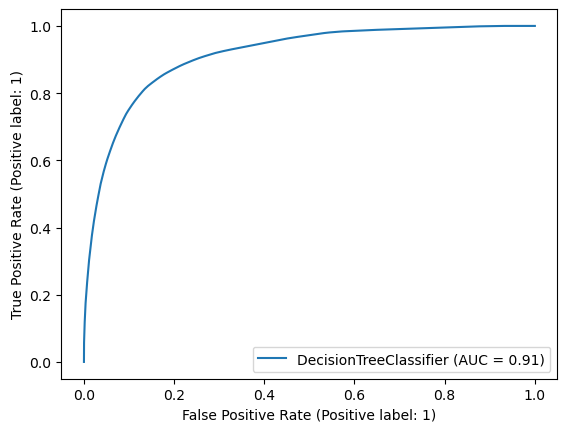

In [113]:
plot_roc_curve(dt_best, X_train, y_train)
plt.show()

In [114]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [115]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     18860
           1       0.63      0.35      0.45      2140

    accuracy                           0.91     21000
   macro avg       0.78      0.66      0.70     21000
weighted avg       0.90      0.91      0.90     21000



In [116]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred, y_test)

0.9133333333333333

#### Thus the accuracy score on test data when using the decision tree after hyperparameter tuning using k fold classification is 91.33

## Using Random Forest

In [117]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [118]:
%%time
rf.fit(X_train, y_train)

Wall time: 1.84 s


RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [119]:
rf.oob_score_

0.9034470091226352

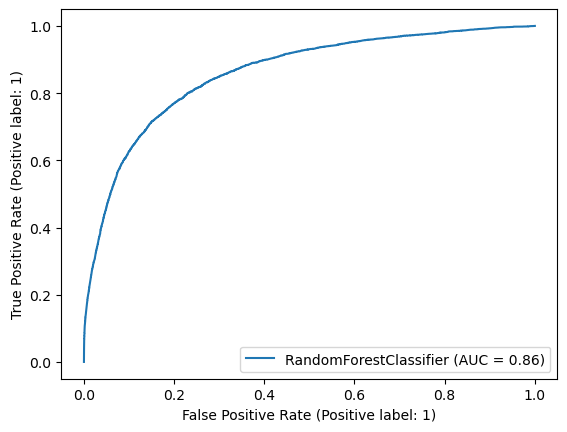

In [120]:
plot_roc_curve(rf, X_train, y_train)
plt.show()

In [121]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [122]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred, y_test)

0.9042380952380953

#### Thus the accuracy score on test data when using the basic random forest with default parameters is 90.42

#### Hyper-parameter tuning for the Random Forest

In [123]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [124]:
params = {
    'max_depth': [2,3,5,10,15,20,25,30,35,40,50],
    'min_samples_leaf': [5,10,20,50,75,100,150,200],
    'n_estimators': [10,20, 25,35, 50,75,100]
}

In [125]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [126]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 616 candidates, totalling 2464 fits
Wall time: 2h 8min 49s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 50],
                         'min_samples_leaf': [5, 10, 20, 50, 75, 100, 150, 200],
                         'n_estimators': [10, 20, 25, 35, 50, 75, 100]},
             scoring='accuracy', verbose=1)

In [127]:
grid_search.best_score_

0.9176513667921246

In [128]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=35, min_samples_leaf=5, n_estimators=35,
                       n_jobs=-1, random_state=42)

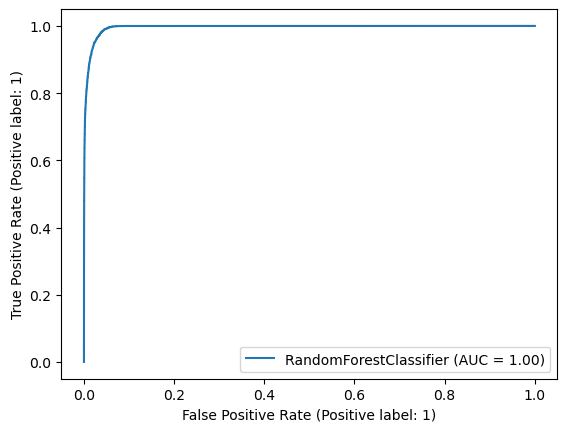

In [129]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

In [130]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

In [131]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     18860
           1       0.71      0.26      0.38      2140

    accuracy                           0.91     21000
   macro avg       0.82      0.63      0.67     21000
weighted avg       0.90      0.91      0.90     21000



In [132]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred, y_test)

0.9140952380952381

#### Thus the accuracy score on test data when using the random forest after hyperparameter tuning using k fold classification is 91.40

# 7. Creating submission file

In [133]:
unseen_data=pd.read_csv("test.csv")
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [134]:
unseen_data.shape

(30000, 171)

In [135]:
unseen_data.isna().sum()

id                              0
circle_id                       0
loc_og_t2o_mou                316
std_og_t2o_mou                316
loc_ic_t2o_mou                316
last_date_of_month_6            0
last_date_of_month_7          202
last_date_of_month_8          367
arpu_6                          0
arpu_7                          0
arpu_8                          0
onnet_mou_6                  1169
onnet_mou_7                  1172
onnet_mou_8                  1675
offnet_mou_6                 1169
offnet_mou_7                 1172
offnet_mou_8                 1675
roam_ic_mou_6                1169
roam_ic_mou_7                1172
roam_ic_mou_8                1675
roam_og_mou_6                1169
roam_og_mou_7                1172
roam_og_mou_8                1675
loc_og_t2t_mou_6             1169
loc_og_t2t_mou_7             1172
loc_og_t2t_mou_8             1675
loc_og_t2m_mou_6             1169
loc_og_t2m_mou_7             1172
loc_og_t2m_mou_8             1675
loc_og_t2f_mou

In [136]:
unseen_data.drop(column_names_with_missing_over_70,axis=1,inplace=True)

In [137]:
unseen_data.shape

(30000, 141)

In [138]:
split_date_to_individual_columns(unseen_data,date_columns)

In [139]:
unseen_data.shape

(30000, 153)

In [140]:
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,last_date_of_month_6_date,last_date_of_month_6_month,last_date_of_month_6_year,last_date_of_month_7_date,last_date_of_month_7_month,last_date_of_month_7_year,last_date_of_month_8_date,last_date_of_month_8_month,last_date_of_month_8_year,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_date,date_of_last_rech_8_month,date_of_last_rech_8_year
0,69999,109,0.0,0.0,0.0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00,30,6,2014,31.0,7.0,2014.0,31.0,8.0,2014.0,21.0,6.0,2014.0,26.0,7.0,2014.0,24.0,8.0,2014.0
1,70000,109,0.0,0.0,0.0,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00,30,6,2014,31.0,7.0,2014.0,31.0,8.0,2014.0,19.0,6.0,2014.0,16.0,7.0,2014.0,24.0,8.0,2014.0
2,70001,109,0.0,0.0,0.0,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.0

In [141]:
unseen_data.tail()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,last_date_of_month_6_date,last_date_of_month_6_month,last_date_of_month_6_year,last_date_of_month_7_date,last_date_of_month_7_month,last_date_of_month_7_year,last_date_of_month_8_date,last_date_of_month_8_month,last_date_of_month_8_year,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_date,date_of_last_rech_8_month,date_of_last_rech_8_year
29995,99994,109,0.0,0.0,0.0,718.870,396.259,406.150,324.46,250.01,285.41,190.36,166.14,221.96,87.76,14.78,0.00,112.43,8.46,0.00,214.99,233.96,277.24,161.76,158.19,193.58,12.09,2.51,6.53,0.00,1.68,0.00,388.86,394.68,477.36,0.91,8.98,8.16,10.29,1.25,21.84,0.0,0.00,0.0,0.0,0.0,0.0,11.21,10.23,30.01,2.31,1.10,0.0,0.00,1.68,0.00,0.0,0.0,0.0,402.39,407.69,507.38,142.58,177.56,281.24,272.21,269.99,344.29,4.81,9.93,10.73,419.61,457.49,636.28,15.21,14.93,9.98,7.25,6.54,16.29,2.83,5.66,1.31,0.0,0.0,0.0,25.29,27.14,27.59,444.91,484.64,663.88,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,8,6,4,669,559,440,220,229,220,0,220,220,21.98,0.00,0.00,45.07,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,1255,3.71,105.64,61.48,30,6,2014,31.0,7.0,2014.0,31.0,8.0,2014.0,27.0,6.0,2014.0,27.0,7.0,2014.0,29.0,8.0,2014.0
29996,99995,109,0.0,0.0,0.0,218.327,324.070,374.981,263.79,467.24,650.26,108.53,124.11,189.76,3.40,0.00,0.00,8.29,0.00,0.00,5.08,17.33,13.16,22.44,33.63,13.03,0.00,0.66,0.00,0.00,0.18,0.00,27.53,51.63,26.19,257.21,449.91,637.09,79.28,85.36,176.73,0.0,0.00,0.0,0.0,0.0,0.0,336.49,535.28,813.83,0.00,0.00,0.0,0.00,4.44,0.00,0.0,0.0,0.0,364.03,591.36,840.03,1.73,18.41,13.99,13.83,24.03,25.49,3.16,10.18,19.28,18.73,52.63,58.78,3.76,10.51,13.55,0.00,1.28,9.59,0.00,0.00,0.00,0.0,0.0,0.0,3.76,11.79,23.14,22.49,64.43,81.93,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,3,3,4,317,298,496,250,169,279,0,110,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,2258,0.00,0.00,0.00,30,6,2014,31.0,7.0,2014.0,31.0,8.0,2014.0,18.0,6.0,2014.0,24.0,7.0,2014.0,29.0,8.0,2014.0
29997,99996,109,0.0,0.0,0.0,139.473,38.230,180.

In [142]:
unseen_data.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','last_date_of_month_6_date','last_date_of_month_6_month','last_date_of_month_6_year','last_date_of_month_7_date','last_date_of_month_7_month','last_date_of_month_7_year','last_date_of_month_8_month','last_date_of_month_8_date','last_date_of_month_8_year','date_of_last_rech_6_year','date_of_last_rech_7_year','date_of_last_rech_8_year'],axis=1,inplace=True)

In [143]:
unseen_data.shape

(30000, 131)

In [144]:
ids=unseen_data.pop("id")

In [145]:
ids.head()

0    69999
1    70000
2    70001
3    70002
4    70003
Name: id, dtype: int64

In [146]:
unseen_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_date,date_of_last_rech_6_month,date_of_last_rech_7_date,date_of_last_rech_7_month,date_of_last_rech_8_date,date_of_last_rech_8_month
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00,21.0,6.0,26.0,7.0,24.0,8.0
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00,19.0,6.0,16.0,7.0,24.0,8.0
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500,1000,1000,300,500,500,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,277,525.61,758.41,241.84,29.0,6.0,27.0,7.0,28.0,8.0
3,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,0.00,0.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,2.94,98.61,20.51,0.00,0.00,2.35,0.0,6.18,0.00,8.26,98.61,22.86,0.00,2.16,0.00,37.09,94.36,0.00,0.0,0.0,0.0,37.09,96.53,0.00

In [147]:
unseen_data.isna().sum()

arpu_6                          0
arpu_7                          0
arpu_8                          0
onnet_mou_6                  1169
onnet_mou_7                  1172
onnet_mou_8                  1675
offnet_mou_6                 1169
offnet_mou_7                 1172
offnet_mou_8                 1675
roam_ic_mou_6                1169
roam_ic_mou_7                1172
roam_ic_mou_8                1675
roam_og_mou_6                1169
roam_og_mou_7                1172
roam_og_mou_8                1675
loc_og_t2t_mou_6             1169
loc_og_t2t_mou_7             1172
loc_og_t2t_mou_8             1675
loc_og_t2m_mou_6             1169
loc_og_t2m_mou_7             1172
loc_og_t2m_mou_8             1675
loc_og_t2f_mou_6             1169
loc_og_t2f_mou_7             1172
loc_og_t2f_mou_8             1675
loc_og_t2c_mou_6             1169
loc_og_t2c_mou_7             1172
loc_og_t2c_mou_8             1675
loc_og_mou_6                 1169
loc_og_mou_7                 1172
loc_og_mou_8  

In [148]:
unseen_data = unseen_data.fillna(0)

In [149]:
unseen_data.isna().sum()

arpu_6                       0
arpu_7                       0
arpu_8                       0
onnet_mou_6                  0
onnet_mou_7                  0
onnet_mou_8                  0
offnet_mou_6                 0
offnet_mou_7                 0
offnet_mou_8                 0
roam_ic_mou_6                0
roam_ic_mou_7                0
roam_ic_mou_8                0
roam_og_mou_6                0
roam_og_mou_7                0
roam_og_mou_8                0
loc_og_t2t_mou_6             0
loc_og_t2t_mou_7             0
loc_og_t2t_mou_8             0
loc_og_t2m_mou_6             0
loc_og_t2m_mou_7             0
loc_og_t2m_mou_8             0
loc_og_t2f_mou_6             0
loc_og_t2f_mou_7             0
loc_og_t2f_mou_8             0
loc_og_t2c_mou_6             0
loc_og_t2c_mou_7             0
loc_og_t2c_mou_8             0
loc_og_mou_6                 0
loc_og_mou_7                 0
loc_og_mou_8                 0
std_og_t2t_mou_6             0
std_og_t2t_mou_7             0
std_og_t

In [150]:
pca_unseen_X = scaler.transform(unseen_data)

In [151]:
pca_unseen_X.shape

(30000, 130)

In [152]:
pca_unseen_X = pc2.transform(pca_unseen_X)

In [153]:
pca_unseen_X.shape

(30000, 60)

In [155]:
pca_unseen_X_df = pd.DataFrame(pca_unseen_X, columns=["PC"+str(x) for x in range(1,61)])
pca_unseen_X_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
0,-3.365689,-0.378917,-0.516148,-0.487359,0.298773,0.046045,0.115140,0.121734,-0.074741,0.056842,0.686790,-0.214558,0.124378,-0.183701,-0.016461,0.111872,0.373822,-1.287024,0.269212,-0.385751,0.691405,1.161482,-0.267914,-0.351194,3.428566,1.203003,0.100849,-0.190670,-0.148801,0.308966,0.317104,-0.262162,-0.129104,-0.196211,0.266538,0.014736,-0.225911,-0.093258,-1.057713,0.886620,0.588973,-0.009682,0.443994,0.044012,0.072860,0.070669,0.022070,0.137883,-0.340200,0.031237,-0.489855,-0.122284,-0.140473,0.012039,-0.020984,0.016696,0.003603,0.069037,-0.083062,0.049842
1,2.816878,2.091698,-0.088197,-2.057009,2.589709,0.825709,-0.513366,1.487205,-0.887973,-0.383750,1.533171,1.950358,1.368724,0.049911,-0.764079,-1.666899,-1.203118,1.575058,-0.385447,-0.170262,-2.190637,-0.143249,0.290978,-0.814935,-0.035312,-0.111634,-1.824700,-0.083059,-0.451713,1.195425,-0.080258,-1.100678,-0.258280,0.353700,-0.661995,0.841246,-0.392192,0.511951,-0.188457,0.379634,0.185787,-0.329367,0.780659,-0.576031,0.319900,-0.670468,0.845520,-0.875578,0.179754,0.807018,-0.075859,-0.058280,-0.119575,-0.305759,0.012147,0.187057,0.097208,0.007322,-0.314076,0.005042
2,-0.674248,-0.694429,3.800563,0.167378,1.139952,0.028879,1.005853,-0.130656,-0.035708,1.900475,-0.669165,-0.180672,0.286189,0.057739,-0.126464,-0.311132,-0.041243,-0.791159,-0.296280,0.149247,0.084820,0.417267,0.003319,-0.940645,-0.538409,-0.642424,0.066349,-1.203502,-1.231609,-0.717333,0.338252,0.611061,-0.086122,-0.149754,0.340628,0.213924,0.200732,-0.249984,0.392321,0.282609,0.202836,0.246791,-2.949249,-0.523803,-0.066652,-0.232565,0.470314,-0.442998,0.332897,0.636602,0.203485,0.296292,-0.129815,0.484548,-0.325332,-0.647568,-0.458769,1.076110,-2.184281,0.247431
3,-0.435249,3.249045,-1.980730,0.241191,-0.499405,1.003867,0.349896,-2.087252,-0.357521,0.392235,0.145816,-0.419010,-0.233629,0.130562,-0.137371,-1.751535,-0.803489,0.718271,-0.635758,-0.111642,-0.072341,-0.453113,-0.262835,-0.087020,0.310266,-1.735286,2.333315,-0.135120,1.042511,-0.983772,0.079193,-0.239588,-0.021820,-0.303918,0.178156,0.273025,0.266809,0.299479,-0.046722,-0.420954,0.307487,-0.195640,-0.234715,-0.344298,0.407146,0.579061,0.273818,0.608417,0.149439,-0.203959,-0.042814,0.062459,-0.329345,0.055849,0.079857,0.101880,0.194974,-0.169601,0.300581,0.059227
4,1.155934,-4.206762,-0.821148,1.442488,-0.008145,-2.886481,1.495765,-0.668119,1.486152,0.010218,0.258738,-0.327380,-0.750441,-0.630862,-0.895465,-1.027692,-0.661251,-0.124116,0.691295,0.227069,-0.038813,0.211783,0.327765,-0.557645,-0.451623,-0.210856,-0.294048,-0.248981,0.092965,-0.271904,0.262803,0.138722,-0.262356,0.264187,0.133755,-0.015117,0.619910,0.063636,0.402312,-0.006129,-0.439282,-0.597520,-0.665886,0.075510,-0.624040,0.670427,-0.315890,0.320253,0.329657,-0.353318,0.071847,0.024230,0.077556,0.014081,0.019989,0.035837,-0.107121,-0.229451,0.028296,-0.027888


In [156]:
sample_df=pd.read_csv("sample.csv")

In [157]:
sample_df.shape

(30000, 2)

In [158]:
sample_df.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [159]:
sample_df.tail()

,id,churn_probability
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0
29999,99998,0


In [160]:
sample_df["churn_probability"] = rf_best.predict(pca_unseen_X_df)

In [161]:
sample_df.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [162]:
sample_df.tail()

,id,churn_probability
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0
29999,99998,0


In [163]:
sample_df.to_csv("sample.csv",index=False)